# Milestone 3 Project 1
Hotel Recommendations using ML Algorithms

Megan Holford<br>
DSC 680 Summer 2022

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import missingno as mn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, plot_confusion_matrix, confusion_matrix
warnings.simplefilter('ignore')

In [2]:
# Loading the data. Our train.csv data set is very large. To minmize memory, we can select a sample from the data.

def load_data(file = "train.csv", nrows = None):
    """"""
    p_dates = ['date_time','srch_ci','srch_co']
    df = pd.read_csv(file, nrows=nrows,
                    parse_dates=p_dates,
                    dtype={'site_name':np.int8,
                           'posa_continent':np.int8,
                           'user_location_country':np.int16,
                           'user_location_region':np.int64,
                           'user_location_city':np.int64,
                           'user_id':np.int64,
                           'is_mobile':np.int8,
                           'is_package':np.int8,
                           'channel':np.int8,
                           'srch_destination_id':np.int64,
                           'srch_children_cnt':np.int8,
                           'srch_rm_cnt':np.int8,
                           'srch_adults_cnt':np.int8,
                           'srch_destination_type_id':np.int8,
                           'is_booking':bool,
                           'cnt':np.int8,
                           'hotel_continent':np.int8,
                           'hotel_country':np.int16,
                           'hotel_market':np.int64,
                           'hotel_cluster':np.int8})
    df['srch_co'] = pd.to_datetime(df['srch_co'],errors = 'coerce')
    df['srch_ci'] = pd.to_datetime(df['srch_ci'],errors = 'coerce')
    return df

df = load_data('train.csv', 100000)

<b>EDA<B>

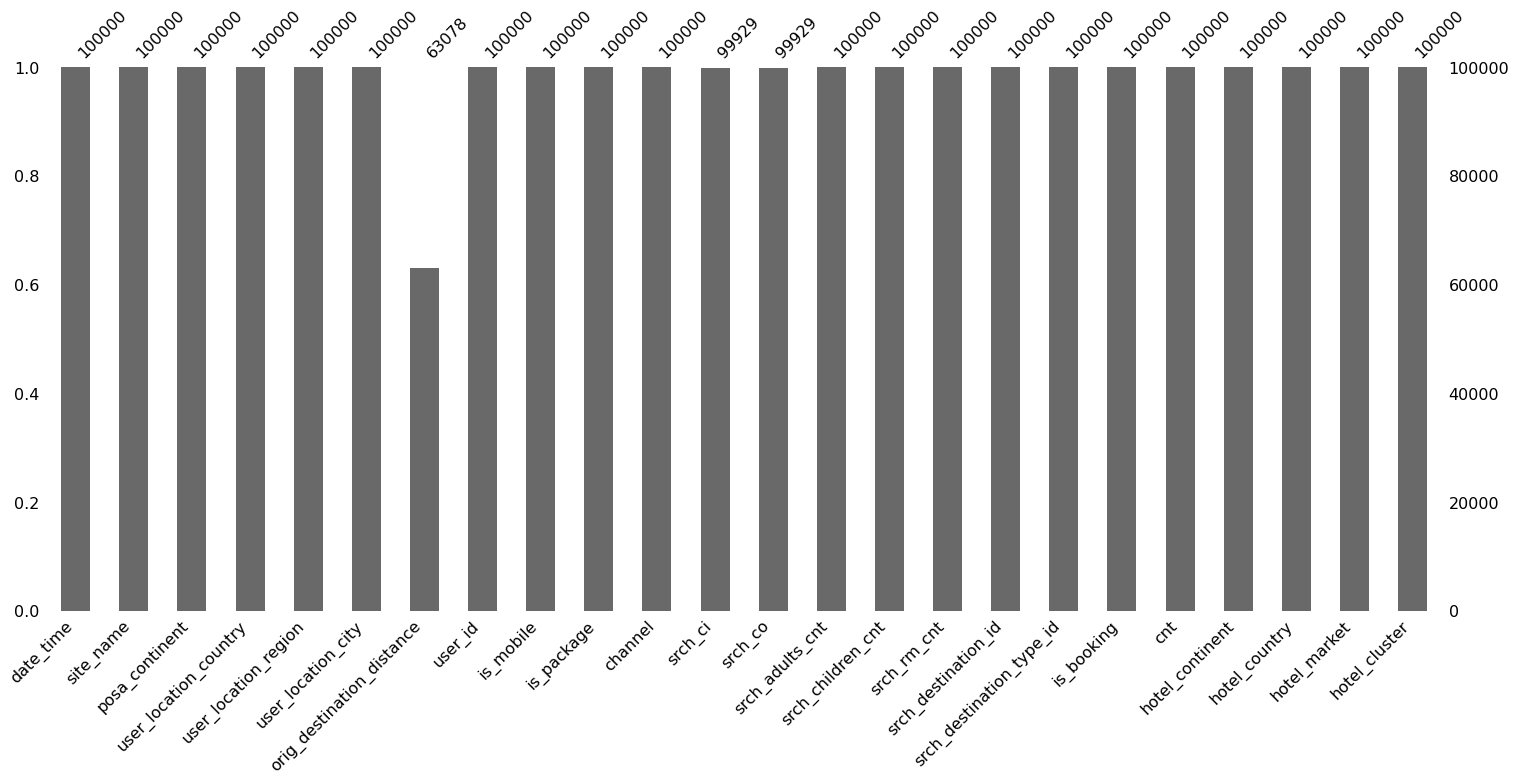

In [3]:
mn.bar(df);


This bar graph shows that there is an unequal distribution for orig_destination_distance. Using EDA is important to see these trends and how to handle them.

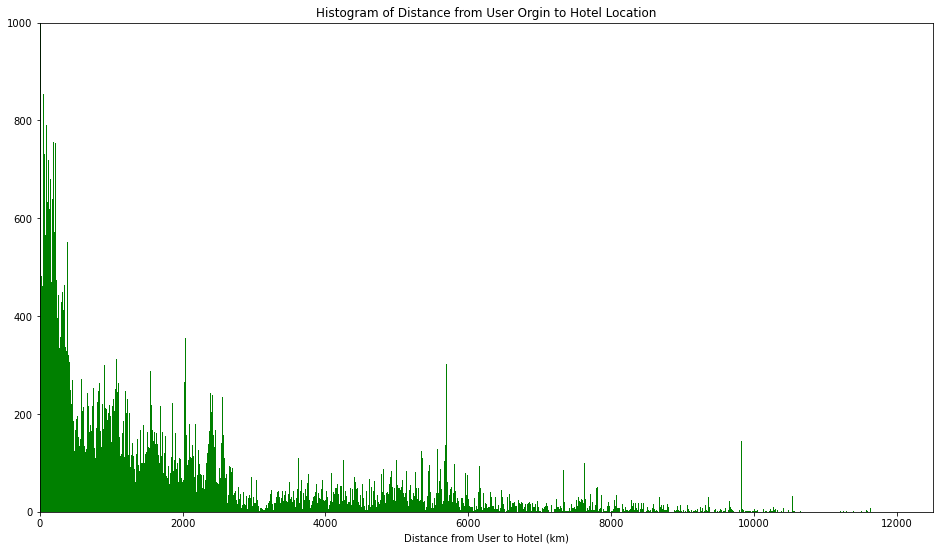

In [5]:
plt.figure(figsize=(16,9))
plt.hist(df['orig_destination_distance'], bins = 1000, color = "green");
plt.ylim(0,1000)
plt.xlim(0,12500)
plt.xlabel("Distance from User to Hotel (km)")
plt.title("Histogram of Distance from User Orgin to Hotel Location")
plt.show()

This shows that the majority of bookings and searches are within 3000 miles of the users location and many values are not represented for longer distances. 

We can also use the data to create new features. Feature engineering is often overlooked in ML techniques but it can be used to create new features from the raw data that can then be used in supervised learning. Training a model with more tailored features can improve accuracy for a specific use case. Next, we can look at how we can use feature engineering on this data set. https://towardsdatascience.com/what-is-feature-engineering-importance-tools-and-techniques-for-machine-learning-2080b0269f10

In [7]:
# What year was the check-in date for.
df['checkin_year'] = df['srch_ci'].dt.year
df = df.dropna(subset=['checkin_year'])
df['checkin_year'] = df['checkin_year'].apply(int)

# What month was the reservation booked for.
df['checkin_month'] = df['srch_ci'].dt.month 

# Day of the week for check-in and check-out.
df['checkin_day'] = df['srch_ci'].dt.weekday
df['checkout_day'] = df['srch_co'].dt.weekday


df['lead_time'] = (df['srch_ci'] - df['date_time']).dt.days
df['nights_stayed'] = (df['srch_co'] - df['srch_ci']).dt.days

# If the reservation was booked for a weekend ie. checking in on Friday and booked multiple nights
df['weekend_booking'] = np.where((df['nights_stayed']<=3) & 
                                 (df['checkin_day']== 4), 1,0)

# Hotel was booked the same day, We can use lead_time to see if a booking was made for same day check-in.
df['same_day'] = np.where((df['lead_time']==0), 1,0)

# Was booked the withing the same week for arrival.
df['same_week'] = np.where((df['lead_time']>0) & (df['lead_time']<=7), 1,0)

# Booking was made in advance.
df['plan_ahead'] = np.where((df['lead_time']>60), 1,0)

# If two or more adults were travelling with at least one child.
df['family_vacation'] = np.where((df['srch_adults_cnt']>=1) & 
                                (df['srch_children_cnt'] >= 1)& 
                                (df['nights_stayed'] >= 4), 1,0)

# Only one adult on the booking and no children.
df['solo_booking'] = np.where((df['srch_adults_cnt']==1) & 
                             (df['srch_children_cnt']== 0) & 
                             (df['srch_rm_cnt'] == 1),1,0)


df['close_to_orign'] = np.where((df['orig_destination_distance'] >= 50),1,0)
df['far_from_orgin'] = np.where((df['orig_destination_distance'] <= 1000),1,0)
df['farthest_from_origin'] = np.where((df['orig_destination_distance'] <= 6000),1,0)

# Booking origin different from destination origin.
df['international_booking'] = np.where((df['user_location_country'] != df['hotel_country']),1,0)

# Nights booked for only a few nights.
df['short_trip'] = np.where((df['nights_stayed'] <= 3),1,0)

# Nights booked more than a week.
df['long_booking'] = np.where((df['nights_stayed'] > 7),1,0)


# Viewing if a booking was in Summer months and for a week or more
df['summer_vacation'] = np.where((df['checkin_month'] >= 6) &
                                 (df['checkin_month'] <= 8) &
                            #     (df['srch_children_cnt'] >= 1) & 
                                 (df['nights_stayed'] > 3),1,0) 



As you can see, here from some of the new features we created, you can use that information to tailor your variables. This can be helpful to make better recommendations as those traveling with children may want a more kid friendly resort or hotel vs adults may want something more upscale. Understanding the user and their searches can help to see those relationships in the data to make recommendations.

In [8]:
pop_df = df.groupby(['srch_destination_id',
                               'srch_destination_type_id',
                               'hotel_country',
                               'hotel_market',
                               'is_package'])['is_booking'].agg(['sum','count']).reset_index()  

pop_df.rename(columns={'count':'clicks', 'sum':'bookings'}, inplace=True)

pop_df['booking_per_click'] = pop_df['bookings'] / (pop_df['clicks'])

pop_df['click_per_booking'] = pop_df['clicks'] / (pop_df['bookings'] + 1)

pop_df['user_engagement'] = (pop_df['clicks'] * 0.05) + (pop_df['bookings'])

pop_df['pop_metric'] = (pop_df['clicks']) + (pop_df['bookings'])


We can also use the data to mark trends over time and how often Guests use online ecommerce sites to book.

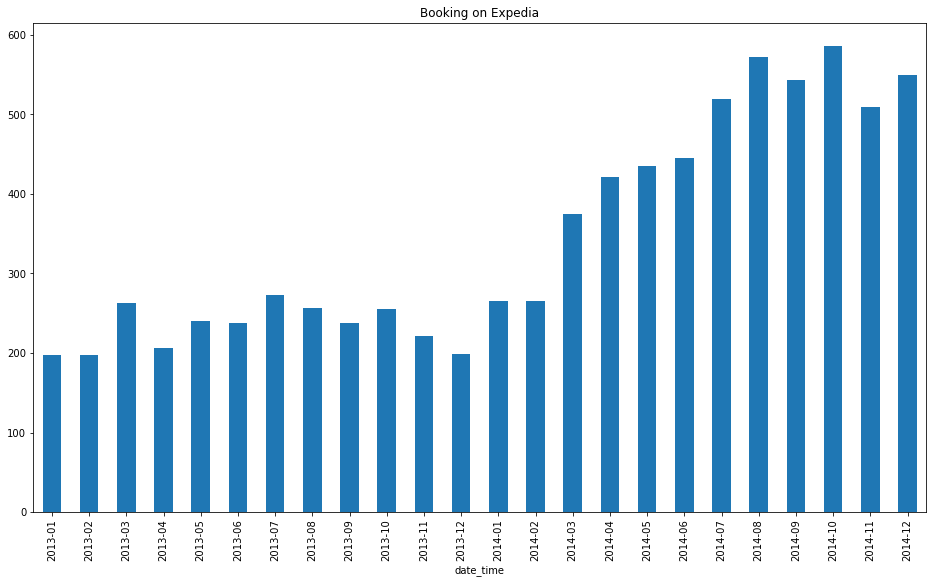

In [11]:

df1 = df.groupby(df['date_time'].dt.to_period('M')).sum()
df1 = df1.resample('M').asfreq().fillna(0)
df1['is_booking'].plot(kind='bar', figsize=(16,9))
plt.title("Booking on Expedia")
plt.show()

Based on the graph, we can see that use of Expedia has increased over the years and more users are booking online. This increase is an important reason to want to make accurate recommendations to improve Guest satisfaction and encourage repeat customers for a positive booking experience. 

Using the data, we can also get an idea on consumer booking habits.

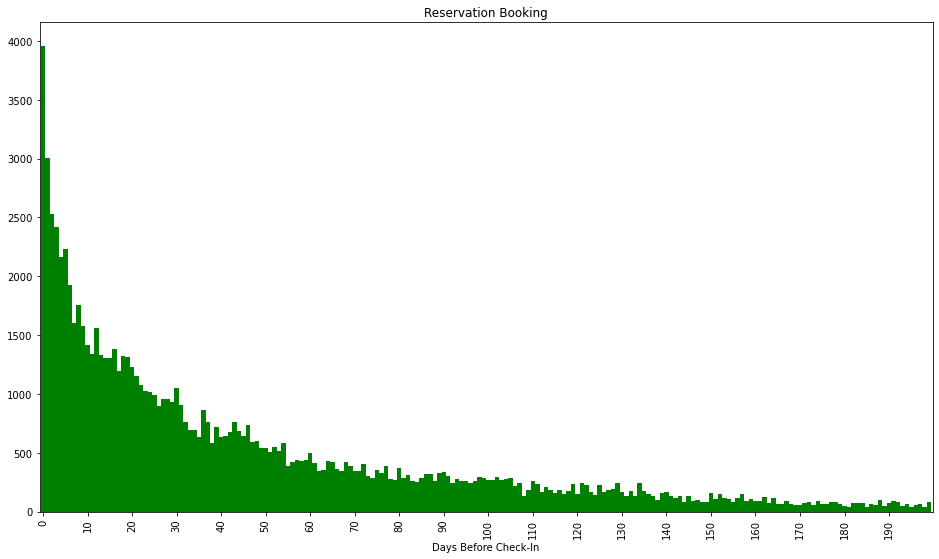

In [14]:
df[(df['lead_time'] >= 0) & (df['lead_time'] < 200)].groupby('lead_time').count()['is_booking'].plot(kind="bar", color="green", figsize=(16,9), xticks=(np.arange(0,200,10)), width = 1)
plt.title("Reservation Booking")
plt.xlabel("Days Before Check-In")
plt.show()

This is a helpful graph to see the distribution on how many days before travel a guest books their accomodation. Per the graph, we can see that the vast majority of bookings are done within 30 days of check-in.

We can also look at the type of bookings that Guests make.

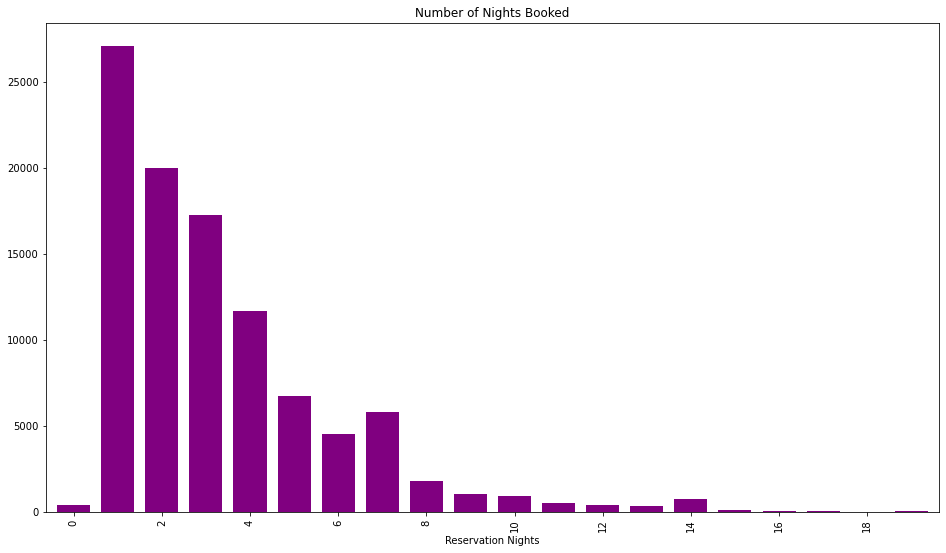

In [16]:
df[(df['nights_stayed'] >= 0) & (df['nights_stayed'] < 20)].groupby('nights_stayed').count()['is_booking'].plot(kind="bar", color="purple", figsize=(16,9), xticks=(np.arange(0,20,2)), width = 0.75)
plt.title("Number of Nights Booked")
plt.xlabel("Reservation Nights")
plt.show()

We can see the distributon of the length of stay that is booked for hotels. 1 night stays are definitely the most common.

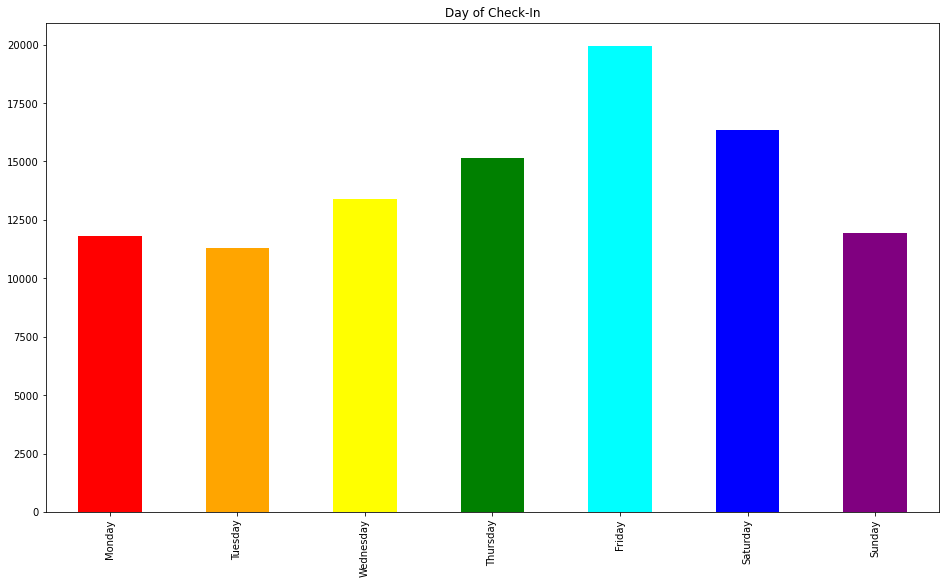

In [17]:
int_to_weekday = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday", 6:"Sunday"}
df['checkin_day'].dropna().apply(lambda x: int_to_weekday[x]).value_counts()[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar', color = ['red','orange','yellow','green','aqua','blue','purple'], figsize=(16,9))
plt.title("Day of Check-In")
plt.show()

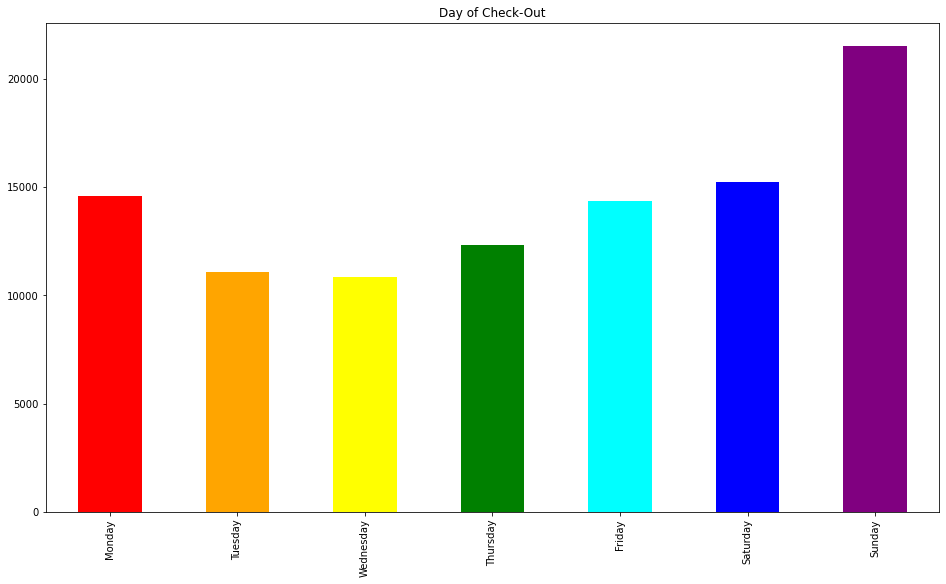

In [18]:
df['checkout_day'].dropna().apply(lambda x: int_to_weekday[x]).value_counts()[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar', color = ['red','orange','yellow','green','aqua','blue','purple'], figsize=(16,9))
plt.title("Day of Check-Out")
plt.show()

These graphs are also helpful to see the most common day of the week that Guests check-in and check-out. Based on Friday being the most popular check-in day and Sunday being popular for check-out, we can use the data to see that many Guests like to book weekend trips. 

In [19]:
# Merging pop_df to compare among other features.
df = pd.merge(df, pop_df, on=['srch_destination_id',
                                     'srch_destination_type_id',
                                     'hotel_country',
                                     'hotel_market',
                                     'is_package'], how='left')

In [20]:
# We want to see what features correlate to actual bookings, so we will set the is_booking to 1 for actual reservations made.
df = df[df['is_booking']==1]


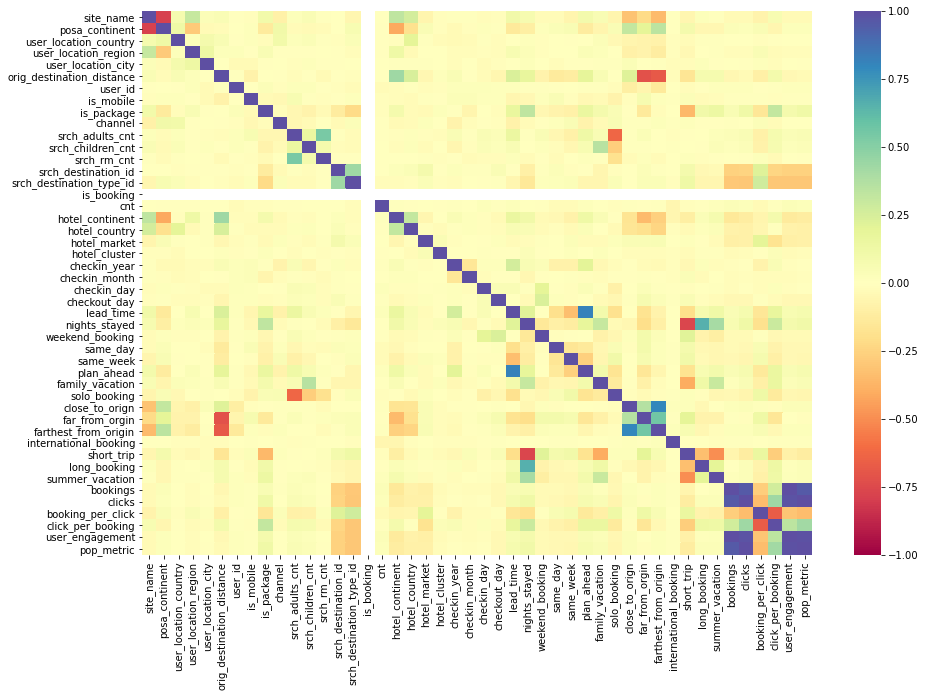

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(df.corr(),cmap='Spectral', vmin=-1, vmax=1, center=False);

<B>Model Preparation<b>

We want to drop values that will not be helpful to our models. We also have our features that we engineered earlier so we want the model to use those to help with the predictions. We will also drop the orig_destination_distance due to the amount of NAN values. 

In [34]:
df.drop(['user_id',
            'srch_ci',
            'srch_co',
            'user_location_city',
            'date_time',
            'orig_destination_distance'], axis =1, inplace =True)


From our data source, we will also add the destinations.csv data as well to our attribute data. We want to set the type so we can run them through the models.

In [35]:
destination = pd.read_csv("destinations.csv", dtype={'d1':np.float16 , 'd2':np.float16 , 'd3':np.float16 , 'd4':np.float16 , 'd5':np.float16 , 'd6':np.float16 , 'd7':np.float16 , 'd8':np.float16 , 'd9':np.float16 , 'd10':np.float16 , 'd11':np.float16 , 'd12':np.float16 , 'd13':np.float16 , 'd14':np.float16 , 'd15':np.float16 , 'd16':np.float16 , 'd17':np.float16 , 'd18':np.float16 , 'd19':np.float16 , 'd20':np.float16 , 'd21':np.float16 , 'd22':np.float16 , 'd23':np.float16 , 'd24':np.float16 , 'd25':np.float16 , 'd26':np.float16 , 'd27':np.float16 , 'd28':np.float16 , 'd29':np.float16 , 'd30':np.float16 , 'd31':np.float16 , 'd32':np.float16 , 'd33':np.float16 , 'd34':np.float16 , 'd35':np.float16 , 'd36':np.float16 , 'd37':np.float16 , 'd38':np.float16 , 'd39':np.float16 , 'd40':np.float16 , 'd41':np.float16 , 'd42':np.float16 , 'd43':np.float16 , 'd44':np.float16 , 'd45':np.float16 , 'd46':np.float16 , 'd47':np.float16 , 'd48':np.float16 , 'd49':np.float16 , 'd50':np.float16 , 'd51':np.float16 , 'd52':np.float16 , 'd53':np.float16 , 'd54':np.float16 , 'd55':np.float16 , 'd56':np.float16 , 'd57':np.float16 , 'd58':np.float16 , 'd59':np.float16 , 'd60':np.float16 , 'd61':np.float16 , 'd62':np.float16 , 'd63':np.float16 , 'd64':np.float16 , 'd65':np.float16 , 'd66':np.float16 , 'd67':np.float16 , 'd68':np.float16 , 'd69':np.float16 , 'd70':np.float16 , 'd71':np.float16 , 'd72':np.float16 , 'd73':np.float16 , 'd74':np.float16 , 'd75':np.float16 , 'd76':np.float16 , 'd77':np.float16 , 'd78':np.float16 , 'd79':np.float16 , 'd80':np.float16 , 'd81':np.float16 , 'd82':np.float16 , 'd83':np.float16 , 'd84':np.float16 , 'd85':np.float16 , 'd86':np.float16 , 'd87':np.float16 , 'd88':np.float16 , 'd89':np.float16 , 'd90':np.float16 , 'd91':np.float16 , 'd92':np.float16 , 'd93':np.float16 , 'd94':np.float16 , 'd95':np.float16 , 'd96':np.float16 , 'd97':np.float16 , 'd98':np.float16 , 'd99':np.float16 , 'd100':np.float16 , 'd101':np.float16 , 'd102':np.float16 , 'd103':np.float16 , 'd104':np.float16 , 'd105':np.float16 , 'd106':np.float16 , 'd107':np.float16 , 'd108':np.float16 , 'd109':np.float16 , 'd110':np.float16 , 'd111':np.float16 , 'd112':np.float16 , 'd113':np.float16 , 'd114':np.float16 , 'd115':np.float16 , 'd116':np.float16 , 'd117':np.float16 , 'd118':np.float16 , 'd119':np.float16 , 'd120':np.float16 , 'd121':np.float16 , 'd122':np.float16 , 'd123':np.float16 , 'd124':np.float16 , 'd125':np.float16 , 'd126':np.float16 , 'd127':np.float16 , 'd128':np.float16 , 'd129':np.float16 , 'd130':np.float16 , 'd131':np.float16 , 'd132':np.float16 , 'd133':np.float16 , 'd134':np.float16 , 'd135':np.float16 , 'd136':np.float16 , 'd137':np.float16 , 'd138':np.float16 , 'd139':np.float16 , 'd140':np.float16 , 'd141':np.float16 , 'd142':np.float16 , 'd143':np.float16 , 'd144':np.float16 , 'd145':np.float16 , 'd146':np.float16 , 'd147':np.float16 , 'd148':np.float16 , 'd149':np.float16 })
df = pd.merge(df, destination, on="srch_destination_id", how='left')
df.fillna(0, inplace=True)

In [36]:
# Splitting the data

X = df.drop(['hotel_cluster'], axis = 1)
y = df['hotel_cluster']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y)


In [38]:

df.head()


,site_name,posa_continent,user_location_country,user_location_region,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,2,3,66,348,0,1,9,2,0,1,...,-2.384766,-2.345703,-2.396484,-2.400391,-2.388672,-2.394531,-2.400391,-2.398438,-2.386719,-2.390625
1,2,3,66,318,0,1,4,2,0,1,...,-2.298828,-2.144531,-2.289062,-2.298828,-2.292969,-2.298828,-2.298828,-2.292969,-2.298828,-2.216797
2,30,4,195,548,0,1,9,2,0,1,...,-2.269531,-2.158203,-2.273438,-2.138672,-2.238281,-2.234375,-2.273438,-2.273438,-2.273438,-2.273438
3,30,4,195,991,0,0,9,2,0,1,...,-2.265625,-2.232422,-2.187500,-2.265625,-2.265625,-2.265625,-2.265625,-2.265625,-2.265625,-2.265625
4,2,3,66,462,0,1,1,3,0,2,...,-2.212891,-2.234375,-2.242188,-2.240234,-2.242188,-2.220703,-2.242188,-2.242188,-2.242188,-2.224609


Now, we can move to the models. I will run a few to find the best model for our data. 

<b>K-Nearest Neighbors<b>


In [39]:
nn = MLPClassifier(hidden_layer_sizes=(500,150), verbose=True)
nn.fit(X_train, y_train)

Iteration 1, loss = 34.38541322
Iteration 2, loss = 7.74818799
Iteration 3, loss = 4.59739330
Iteration 4, loss = 4.59085840
Iteration 5, loss = 4.58417301
Iteration 6, loss = 4.92060269
Iteration 7, loss = 4.57087590
Iteration 8, loss = 4.56566743
Iteration 9, loss = 4.55969983
Iteration 10, loss = 4.55419933
Iteration 11, loss = 4.54898436
Iteration 12, loss = 4.88118077
Iteration 13, loss = 4.53875347
Iteration 14, loss = 4.53384196
Iteration 15, loss = 4.52913853
Iteration 16, loss = 4.52466973
Iteration 17, loss = 4.52033532
Iteration 18, loss = 4.51616813
Iteration 19, loss = 4.51201473
Iteration 20, loss = 4.63795079
Iteration 21, loss = 4.50428697
Iteration 22, loss = 4.50072838
Iteration 23, loss = 4.49721090
Iteration 24, loss = 4.49382479
Iteration 25, loss = 4.57084771
Iteration 26, loss = 4.48692168
Iteration 27, loss = 4.48384354
Iteration 28, loss = 4.48093653
Iteration 29, loss = 4.66996082
Iteration 30, loss = 4.60258543
Iteration 31, loss = 4.47261932
Iteration 32, lo

MLPClassifier(hidden_layer_sizes=(500, 150), verbose=True)

In [40]:
y_pred = nn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average='macro')*100:.2f}%")

Accuracy: 3.72%
Precision: 0.04%
Recall: 1.00%


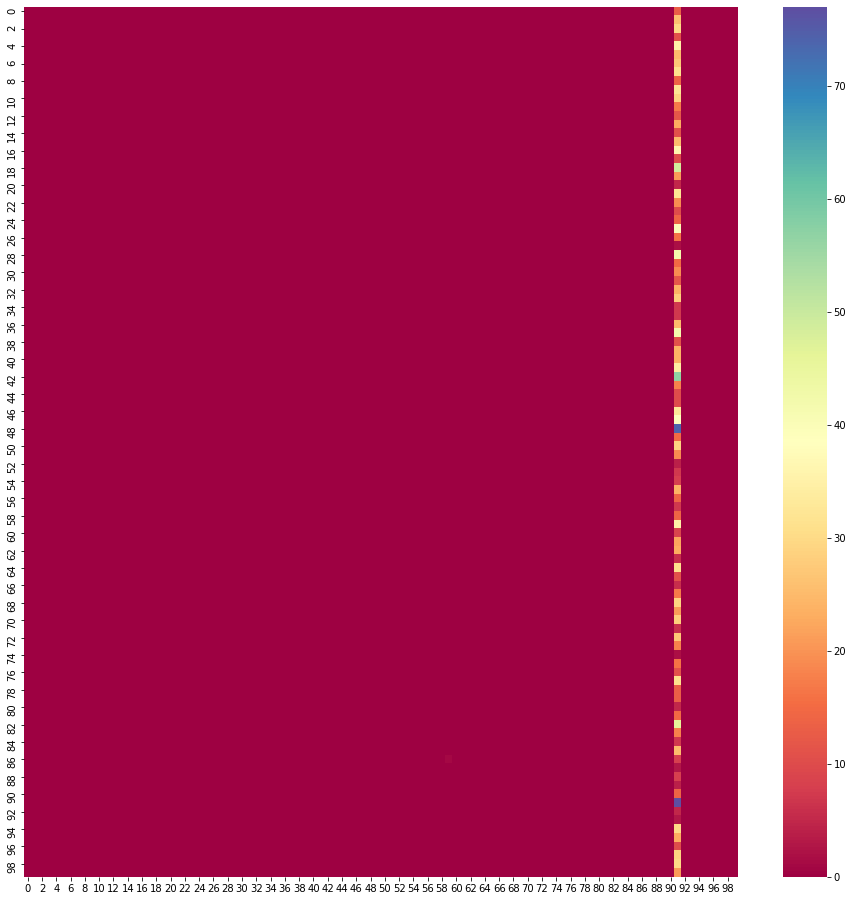

In [42]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
fig.set_size_inches(16,16)
sns.heatmap(cm, cmap="Spectral", ax = ax);

<b>Decision Tree<b>

In [43]:


tree_model = DecisionTreeClassifier()
tree_model.fit(X=X_train,y=y_train)
y_pred_tree = tree_model.predict(X=X_test)

In [44]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_tree,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_tree, average='macro')*100:.2f}%")

Accuracy: 15.28%
Precision: 15.11%
Recall: 14.95%


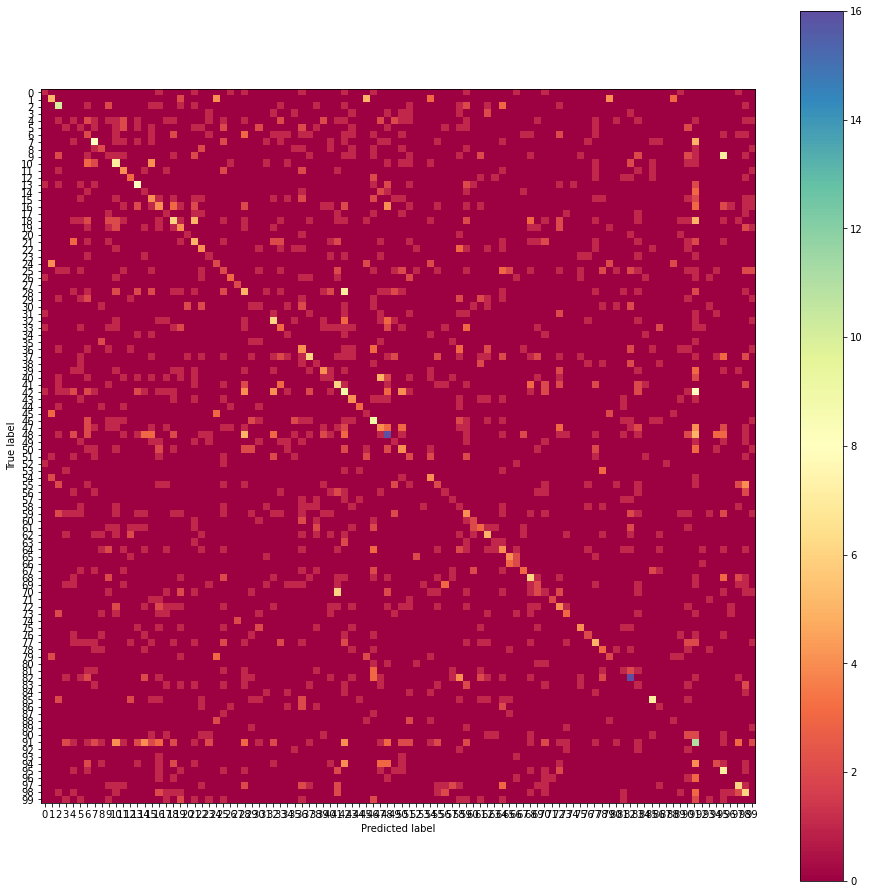

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(16,16)
plot_confusion_matrix(tree_model, X_test, y_test, ax=ax,include_values=False, cmap="Spectral");

<b>Random Forest<b>

In [48]:

forest = RandomForestClassifier()
forest.fit(X=X_train,y=y_train)
y_pred_forest = forest.predict(X=X_test)

In [49]:
# Accuracy, recall, and precision
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_forest,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_forest, average='macro')*100:.2f}%")

Accuracy: 19.58%
Precision: 20.00%
Recall: 18.06%


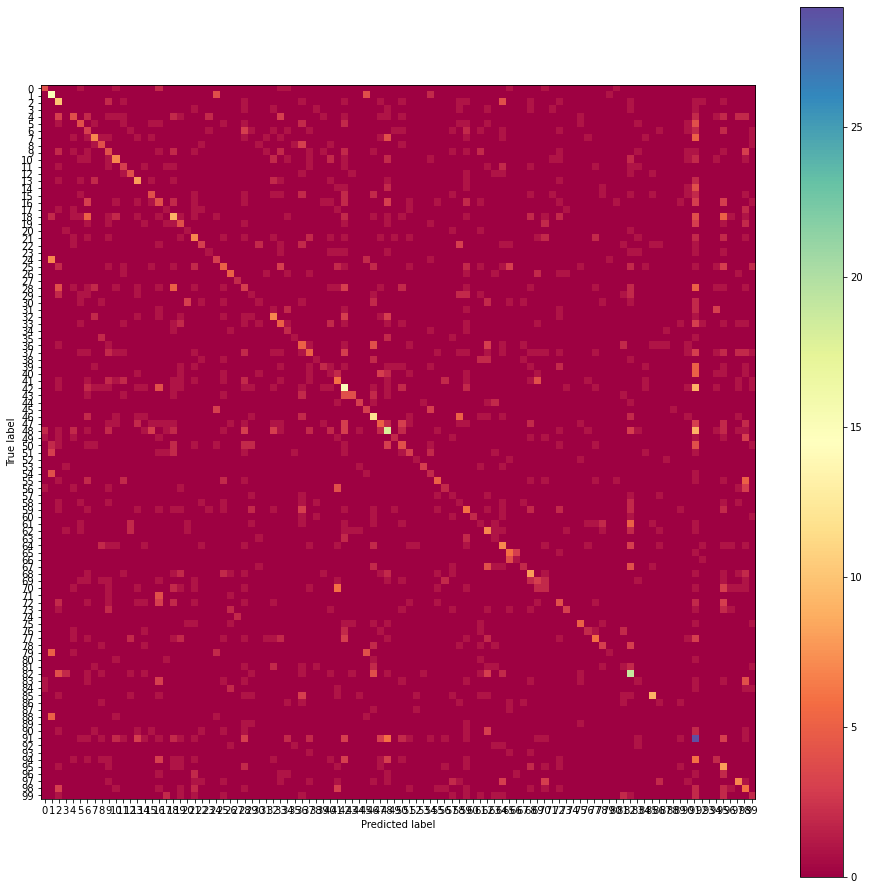

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(16,16)
plot_confusion_matrix(forest, X_test, y_test, ax=ax,include_values=False, cmap="Spectral");